# Inicializações

In [1]:
!nvidia-smi

Wed Jun 25 13:33:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          On  |   00000000:1B:00.0 Off |                    0 |
| N/A   26C    P0             68W /  700W |      14MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
else:
    BASE_PATH = "/lapix"
    VISIBLE_GPUS = [7]

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())

os.chdir(BASE_PATH)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0
Running on Google Colab =  False
CUDA GPUS NUMBER:  1


## Importe e instale as bibliotecas

Só faz sentido rodar isto daqui se você está no Google Colab, onde a máquina virtual é destruída quando você termina de usar o notebook e tem que repetir a instalação da próxima vez que usar.

Se estiver rodando no Jupyter em seu computador, você já deve ter configurado estas bibliotecas no seu ambiente Anaconda.

Caso não tenha configurado o Anaconda com fast.ai, execute esta célula **apenas uma vez**, se vier a rodar o notebook no seu computador mais vezes, não vai necessitar repetir esta célula. A instalação das bibliotecas será permanente.

In [3]:
INSTALL_LIBS = False # Setar para True para instalar localmente também (Não é necessário se estiver rodando nos conteiners Lapix)

if _ON_COLAB:
    INSTALL_LIBS = True

if INSTALL_LIBS:
    !pip install lapixdl
    !pip install -U albumentations
    !pip install fastai


Sempre execute esta célula, não importa se no seu computador ou no Colab. Ela vai importas as bibliotecas para dentro da máquina virtual do notebook.

In [4]:
import random
from pathlib import Path

import albumentations as A
import numpy as np
import pandas as pd
from fastai.vision.all import *
from lapixdl.evaluation.evaluate import evaluate_classification
from lapixdl.evaluation.model import Classification

# Fix seed
random.seed(81615)

/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Definição de Funções Utilitárias

### Função para realizar transformações aleatórias nas imagens para aumentação de dados de maneira sintética.

In [5]:
class AlbumentationsTransform(Transform):
    split_idx = 0

    def __init__(self, aug):
        self.aug = aug

    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))["image"]
        return PILImage.create(aug_img)

## Conecte o seu Google Drive

Se você deseja carregar um **conjunto de dados cutomizado** seu e ele está no seu Google Drive ou então você deseja **salvar os resultados deste notebook depois da execução**, utilize esta célula aqui para conectar o notebook ao Drive.  Ele será montado na pasta "gdrive" do Colab. Nesta pasta vai aparecer todo o conteúdo do seu Google Drive.  

In [5]:
from google.colab import drive
import os
drive.mount(os.path.join(BASE_PATH, "gdrive"), force_remount=True)
DRIVE_BASE_PATH = os.path.join(BASE_PATH, "gdrive")

Mounted at /content/gdrive


# Configuração dos Paths e Metadados e Carga dos Conjuntos de Dados

Preenchemos os paths de acordo com a estrutura do dataset e os diretórios de output

Este notebook oferece 3 opções de carga de conjuntos de dados de treinamento. Escolha a sua de acordo com a disciplina na qual você estiver usando o notebook ou dos objetivos do seu trabalho.

##DATASET CUSTOM


In [6]:
pwd

'/lapix'

In [5]:
base_path = Path("/lapix/compartilhado/Stephan/flower-classification")
path_dataset = (base_path / "dataset")
path_img = (base_path / "images")  # Images root folder. The images must be inside the [train|val|test]/[class] folders.
path_output = (base_path / "output")
path_models = (
    path_output / "models"
)  # Folder where the models/weights should be saved in

path_models.mkdir(parents=True, exist_ok=True)

\


### Função auxiliar para gerar um subset com 'n' números de imagens. Neste notebook o seu propósito é em auxiliar na divisão dos conjuntos de treino, teste e validação.


In [9]:
import shutil
import random
def random_sample_images(dirpath, destfolder, nimages):
  files_list = os.listdir(dirpath)
  for filename in random.sample(files_list, nimages):
    shutil.copy(os.path.join(dirpath, filename), os.path.join(destfolder, filename))


### Criar os diretórios onde os dados estarão de acordo com o formato esperado e realizar a separação nos conjuntos de treino, teste e validação com sua devida proporção e para seus diretórios previamente criados.


In [17]:
PATH_DATASET = path_dataset
PATH_TRAIN = os.path.join(PATH_DATASET, "train")
PATH_VAL = os.path.join(PATH_DATASET, "val")
PATH_TEST = os.path.join(PATH_DATASET, "test")
os.makedirs(PATH_DATASET, exist_ok=True)
os.makedirs(PATH_TRAIN, exist_ok=True)
os.makedirs(PATH_VAL, exist_ok=True)
os.makedirs(PATH_TEST, exist_ok=True)
os.chdir(os.path.join(path_img))
dirnames = os.listdir('.')
datadict = {}
flower_class_allowed = ["daisy", "rose", "sunflower", "tulip", "dandelion", "coreopsis", "daffodil", "carnation", "bellflower", "magnolia"]
for dir_name in dirnames:
  if dir_name not in flower_class_allowed:
    continue
  os.makedirs(os.path.join(PATH_TRAIN,dir_name), exist_ok=True)
  os.makedirs(os.path.join(PATH_VAL,dir_name), exist_ok=True)
  os.makedirs(os.path.join(PATH_TEST,dir_name), exist_ok=True)
  datadict[dir_name] = len([fname for fname in os.listdir(os.path.join(dir_name,'.')) if os.path.isfile(os.path.join(dir_name,fname))])

train_rate = 0.8 # proporção dos arquivos que serão utilizados para treino - 80%
val_rate = 0.1 # proporção dos arquivos que serão utilizados para validação - 10%
test_rate = 0.1 # proporção dos arquivos que serão utilizados para teste - 10%
for key in datadict:
  images_to_train = int(datadict[key] * train_rate)
  images_to_val = int(datadict[key] * val_rate)
  images_to_test = int(datadict[key] * test_rate)
  print(key)
  random_sample_images(key, os.path.join(PATH_TRAIN, key), images_to_train)
  random_sample_images(key, os.path.join(PATH_VAL, key), images_to_val)
  random_sample_images(key, os.path.join(PATH_TEST, key), images_to_test)
os.chdir(BASE_PATH)

print(datadict)

rose
bellflower
tulip
sunflower
daffodil
carnation
daisy
dandelion
coreopsis
magnolia
{'rose': 321, 'bellflower': 300, 'tulip': 262, 'sunflower': 242, 'daffodil': 252, 'carnation': 299, 'daisy': 300, 'dandelion': 302, 'coreopsis': 300, 'magnolia': 289}


### Definir o caminho base do conjunto de dados, o caminho de saída da rede e o prefixo de nomeclatura dos pesos do modelo.


#CNN Model

*   resnet18, resnet34, resnet50, resnet101, resnet152
*   squeezenet1_0, squeezenet1_1
*   densenet121, densenet169, densenet201, densenet161
*   vgg16_bn, vgg19_bn
*   alexnet

Uma lista completa de modelos disponível em: https://github.com/fastai/fastai/tree/2.5.3/fastai/vision/models

In [7]:
from fastai.vision.models import resnet50

used_model = resnet50

## Train pipeline setup

### Pipeline

In [20]:
import albumentations as A
# Gerar aumentação de dados sintéticos
augmentations = A.Compose(
    [
        A.Resize(height=244, width=244, p=1),
        A.HorizontalFlip(p=0.5),
        A.Rotate((-10, 10), p=0.75),
        A.RandomBrightnessContrast(0.1, 0.1, p=0.75),
        A.Affine(p=0.75, shear=0.2)
    ]
)

transforms = [AlbumentationsTransform(augmentations)]

In [42]:
import os

folder = "/content/dataset"

for filename in os.listdir(folder):
    for filename2 in os.listdir("/content/dataset/" + filename):
      if filename.endswith(".git"):
        continue
      full_path = os.path.join(folder, filename)
      if os.path.isfile(full_path) and not filename.endswith(".jpg"):
          new_name = full_path + ".jpg"
          os.rename(full_path, new_name)

In [6]:
# Definir o array das métricas
metrics = [
    accuracy,
    F1Score(average="macro"),
    Precision(average="macro"),
    Recall(average="macro"),
]

#Carregando o Dataloader

Abaixo há dois métodos diferentes de carregar o dataset para dentro do dataloader da rede neural. Ambos vão funcionar:

* Pandas é uma biblioteca de visualização de dados em matriz e oferece rotinas de carga
* Há também as rotinas d ecarga ntivas do fast.ai qque você pode usarde froma simples.

In [22]:
# Defina o tamanho do seu lote de imagens para processamento pela rede
bs = 8
path_dataset = Path(PATH_DATASET)
# Carregue os dados usando função nativa do fast.ai
data = ImageDataLoaders.from_folder(path_dataset, train='train', valid='val', test=Path(os.path.join(PATH_DATASET, "test"))
                                    ,bs=bs,item_tfms=Resize(244),
                                    batch_tfms=[*aug_transforms(size=244), Normalize.from_stats(*imagenet_stats)],)

#Definindo Learner
Carregar as inicializações básicas para o aprendizado e definição dos parâmetros básicos da rede.

In [10]:
def get_learner(data, load_model=None, unfreeze:bool=False):
  """Creates and setups the learner for each step of the training approach.

  Args:
      data: Dataloader.
      load_model (str): Path to the model to be loaded.
      unfreeze (bool): Indicates if the model should be unfreezed. Defaults to False.
  """
  learn = vision_learner(data,
                      used_model,
                      metrics=metrics,
                      loss_func=CrossEntropyLossFlat()).to_fp16()

  learn.path = path_models
  if(load_model != None):
    learn.load(load_model)
  if(unfreeze):
    learn.unfreeze()
  return learn

# Treinamento Inicial: Transfer Learning


## Visualizando um batch do conjunto de dados

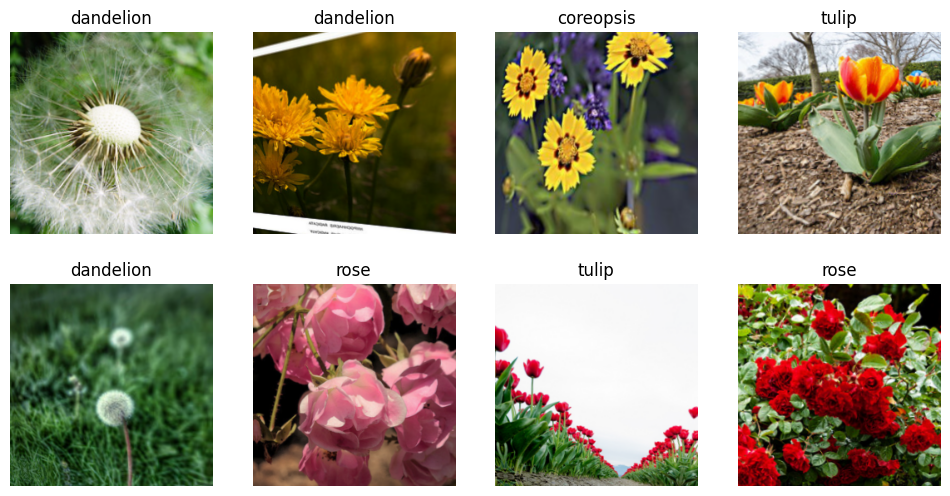

In [24]:
data.show_batch()

## Procurar a melhor taxa de aprendizado utilizando o método 'built-in' do fast.ai

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]
/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, *

SuggestedLRs(valley=0.0014454397605732083)

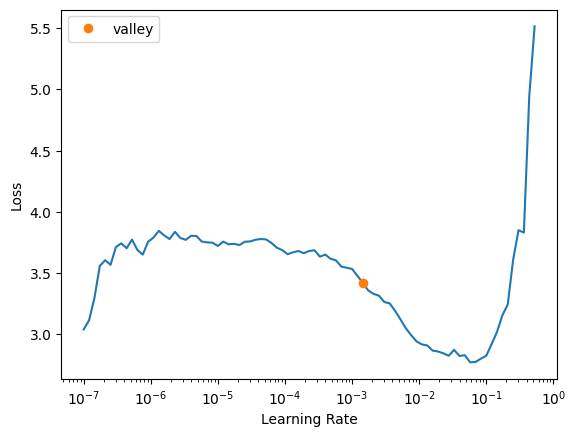

In [25]:
# Runs the learning rate finder
get_learner(data).lr_find()

Better model found at epoch 0 with f1_score value: 0.8155988999996637.


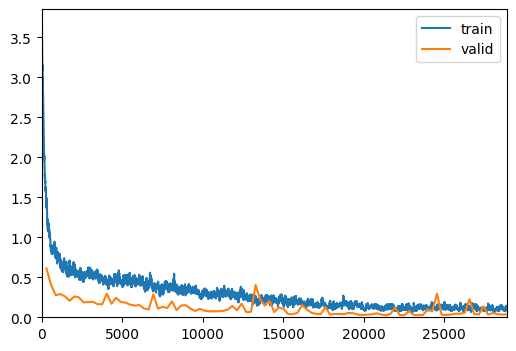

Better model found at epoch 1 with f1_score value: 0.8851036113888535.
Better model found at epoch 2 with f1_score value: 0.9260786010967834.
Better model found at epoch 4 with f1_score value: 0.9317246892178248.
Better model found at epoch 5 with f1_score value: 0.9432232701790332.
Better model found at epoch 10 with f1_score value: 0.9439193119087875.
Better model found at epoch 11 with f1_score value: 0.9615876394695677.
Better model found at epoch 22 with f1_score value: 0.9627773948224375.
Better model found at epoch 23 with f1_score value: 0.9632436362628776.
Better model found at epoch 25 with f1_score value: 0.9644667194162031.
Better model found at epoch 26 with f1_score value: 0.9675854810346657.
Better model found at epoch 28 with f1_score value: 0.9732324750908425.
Better model found at epoch 34 with f1_score value: 0.9796053629181654.
Better model found at epoch 37 with f1_score value: 0.9804766440292093.
Better model found at epoch 43 with f1_score value: 0.98063776718402

/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, *

In [26]:
import torch
import numpy
import functools

lr = slice(2e-3)  # Incluir aqui a taxa de aprendizado encontrada no passo anterior
wd = 1e-2  # decaimento da rede
TRAIN_EPOCH = 100
learn = get_learner(data)
callbacks = [
    SaveModelCallback(
        monitor="f1_score", fname="best_model_stg1", with_opt=False
    ),  # Saves the best model as `fname` in `learn.path` considering the metric defined in `monitor`.
    ShowGraphCallback(),  # Shows the train/validation graph
]

# Train
learn.fit_one_cycle(TRAIN_EPOCH, lr_max=lr, wd=wd, cbs=callbacks)

## Mostrar Resultados do Transfer Learning

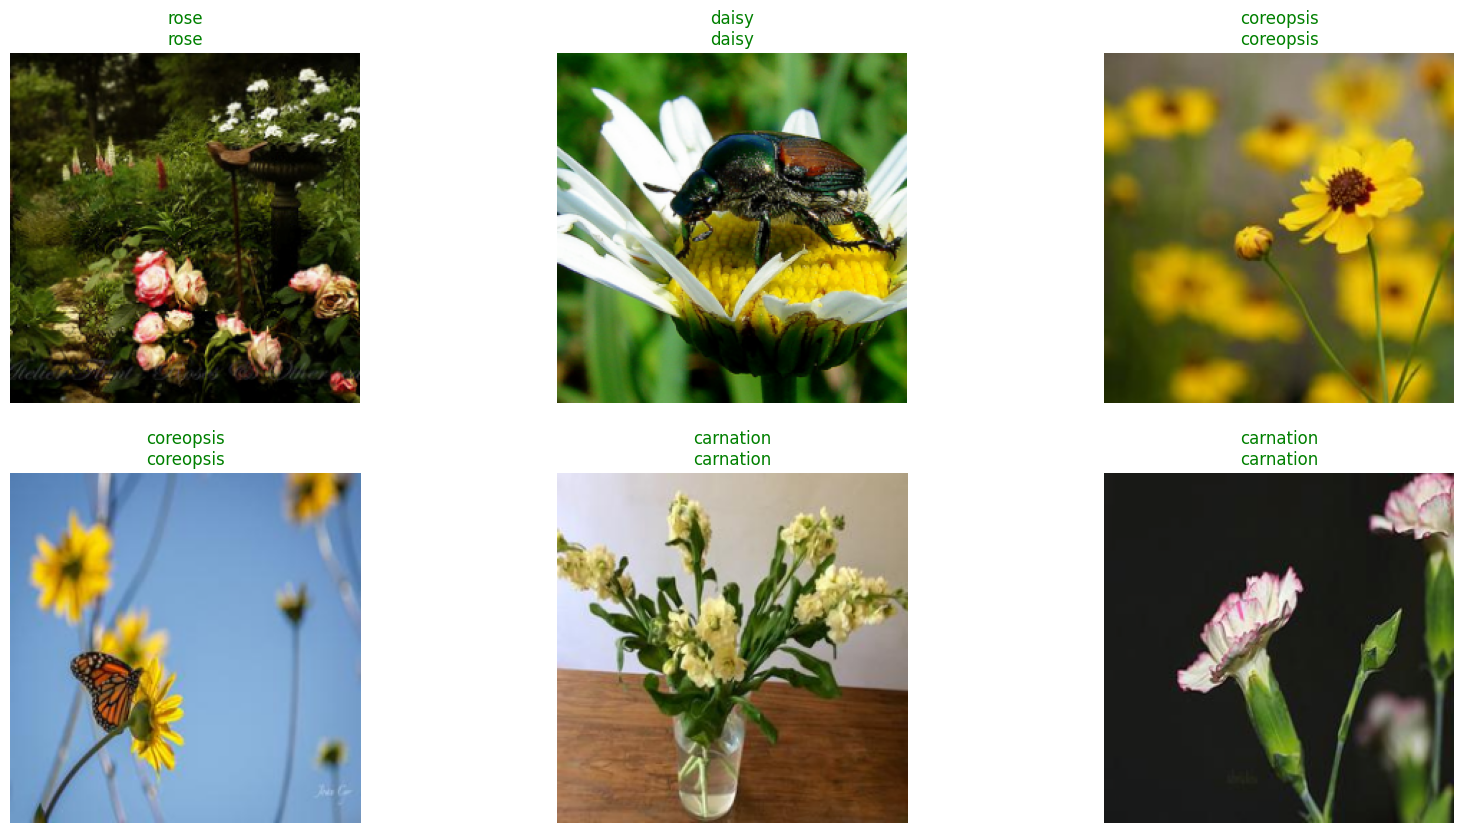

In [34]:
get_learner(data, "best_model_stg1").show_results(
    max_n=6, figsize=(20, 10)
)  # Mostra exemplos de resultado do modelo definido

## Determinamos o novo learning rate para o Finetuning

In [35]:
# Load the learner with the best_model_stg1 weights but DO NOT unfreeze yet
get_learner(data, "best_model_stg1", unfreeze=True).lr_find() # You can optionally pass a range like (start_lr, end_lr) based on the first run

/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, *

IndexError: index 0 is out of bounds for dimension 0 with size 0

#Treinamento do Finetuning

Better model found at epoch 0 with f1_score value: 0.9838539135103452.


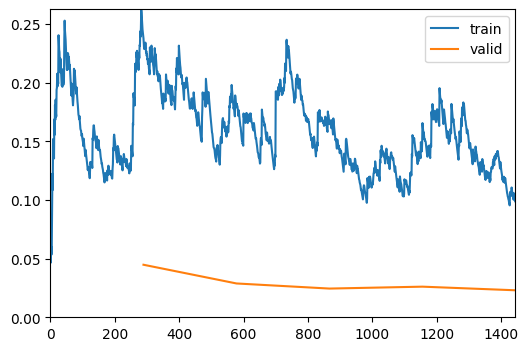

Better model found at epoch 1 with f1_score value: 0.9940854673245856.
Better model found at epoch 3 with f1_score value: 0.9972112304503487.


/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, *

In [36]:
lr = slice(1.5e-5, 5e-4) # nova taxa de aprendizado encontrada
wd = 1e-2
TRAIN_EPOCH = 5
learn = get_learner(data, "best_model_stg1", True) # definir como peso inicial o peso treinado anteriormente
callbacks = [
    SaveModelCallback(monitor="f1_score", fname="best_model_stg2", with_opt=False),
    ShowGraphCallback(),
] # definir um novo nome para o peso do finetuning.

# Iniciar treinamento
learn.fit_one_cycle(TRAIN_EPOCH, lr_max=lr, wd=wd, cbs=callbacks)

## Mostramos os resultados

/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/learner.py:61: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")
/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


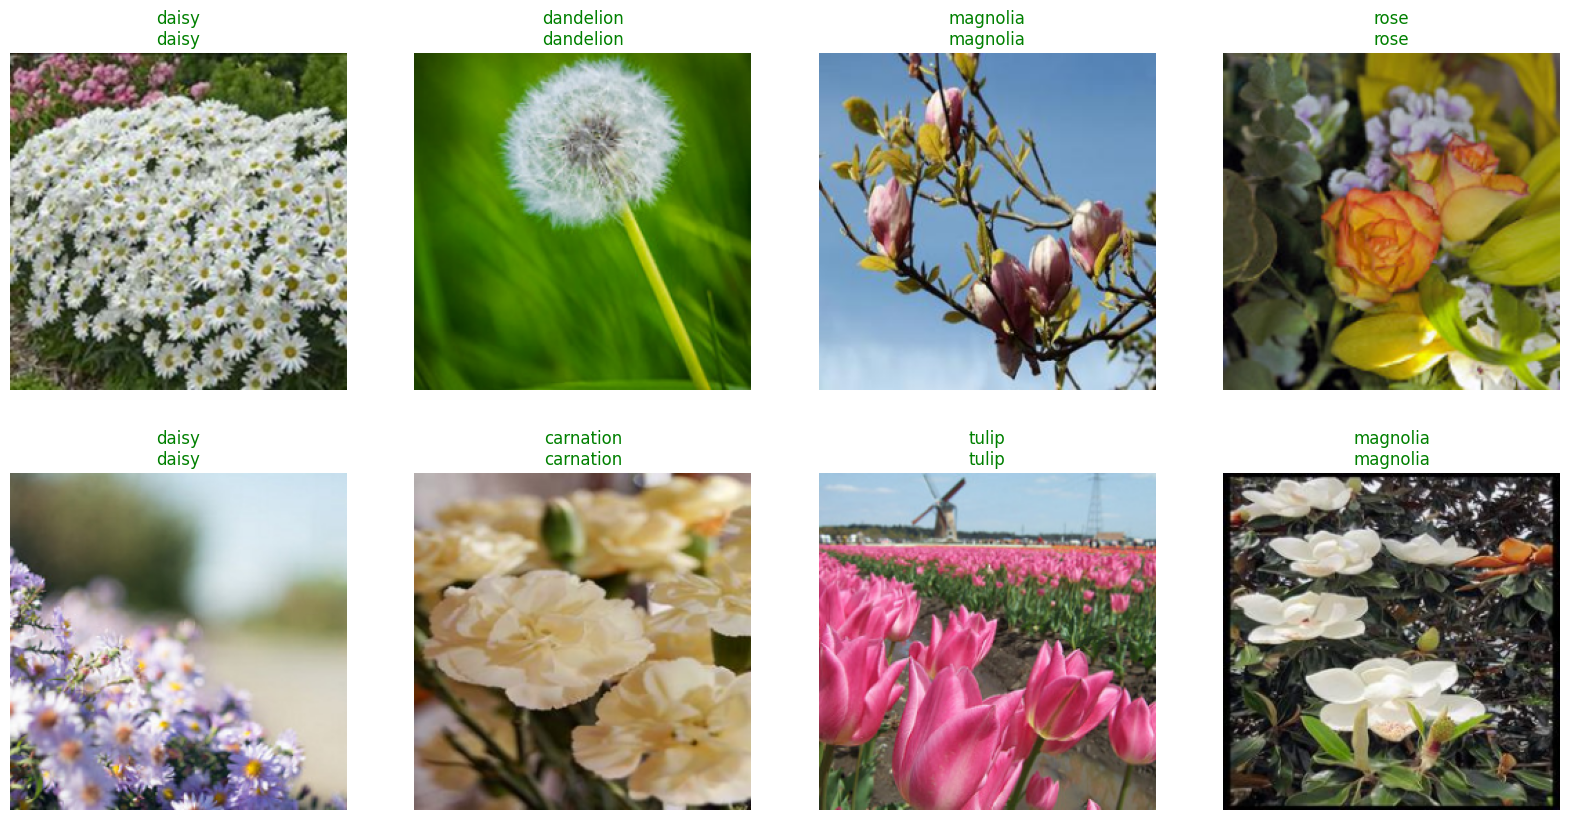

In [37]:
get_learner(data, "best_model_stg2").show_results(max_n=16, figsize=(20, 10))

## Test

Rodamos as evaluations das métricas no test set

In [38]:
bs = 1
path_test = path_dataset / "test"
data_test = ImageDataLoaders.from_folder(path = path_dataset,train='test',valid='test',test = path_test, bs=bs,
                                    batch_tfms=Normalize.from_stats(*imagenet_stats),)

In [39]:
learn = get_learner(data_test, "best_model_stg2") # utilizamos como teste o último peso do modelo treinado
ds_test = data_test.valid_ds

/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, *

#Test Functions

In [11]:
from IPython.display import Image
# Iterators to convert to the LapixDL input format

def gt_classifications(ds):
    for (img, cls) in ds:
        yield Classification(int(cls))


def pred_classifications(ds):
    for (img, cls) in ds:
        (cls_name, pred_cls, scores) = learn.predict(img)
        yield Classification(int(pred_cls), scores[int(pred_cls)])


def top5(img):
  pred_class, pred_idxs, outputs = learn.predict(img)
  top_5_conf, i = outputs.topk(5)
  itr = 0
  classes = data.classes
  for x in i:
    print("Class: %s, Probability: %.4f %%"%(classes[x.item()], top_5_conf[itr].item()*100))
    itr=itr+1
  print()

def get_prediction(img,correct):
  pred_class, pred_idxs, outputs = learn.predict(img)
  classes = data.classes
  out = list(outputs)
  index = classes.index(correct)
  prediction = out[index]
  print("%.10f %%"%(prediction.item()*100))
  print()

In [43]:
evaluation_test = evaluate_classification(
    gt_classifications(ds_test), pred_classifications(ds_test), ds_test.vocab
)

print(evaluation_test)

0 samples [00:00, ? samples/s]

/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


Classification Metrics:
	Sample Count: 302
	Accuracy: 0.9437086092715232
	Avg Recall: 0.9474117186576864
	Avg Precision: 0.9479835517189521
	Avg Specificity: 0.993689430393788
	Avg FPR: 0.006310569606212071
	Avg F-Score: 0.9472795904638159

By Class:

bellflower:
	TP: 28
	TN: 267
	FP: 4
	FN: 3
	FPR: 0.014760147601476014
	Accuracy: 0.9768211920529801
	Recall: 0.9032258064516129
	Precision: 0.875
	Specificity: 0.985239852398524
	F-Score: 0.8888888888888888
carnation:
	TP: 29
	TN: 269
	FP: 3
	FN: 1
	FPR: 0.011029411764705883
	Accuracy: 0.9867549668874173
	Recall: 0.9666666666666667
	Precision: 0.90625
	Specificity: 0.9889705882352942
	F-Score: 0.9354838709677419
coreopsis:
	TP: 30
	TN: 271
	FP: 0
	FN: 1
	FPR: 0.0
	Accuracy: 0.9966887417218543
	Recall: 0.967741935483871
	Precision: 1.0
	Specificity: 1.0
	F-Score: 0.9836065573770492
daffodil:
	TP: 25
	TN: 275
	FP: 1
	FN: 1
	FPR: 0.0036231884057971015
	Accuracy: 0.9933774834437086
	Recall: 0.9615384615384616
	Precision: 0.9615384615384616
	S

#Plotamos a matriz de confusão

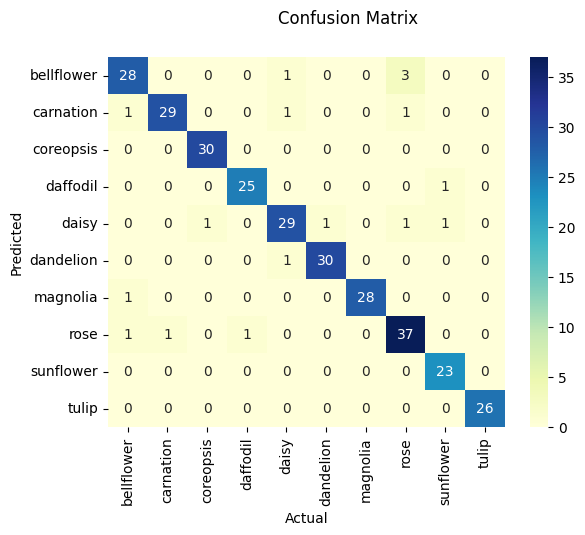

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Actual', ylabel='Predicted'>)

In [46]:
evaluation_test.show_confusion_matrix()

In [56]:
bs = 1
path_our_images = path_dataset / "our_images"
data_our_images = ImageDataLoaders.from_folder(
    path = path_dataset,
    train='our_images',
    valid='our_images',
    test = path_our_images,
    bs=bs,
    item_tfms=Resize(244),
    batch_tfms=[*aug_transforms(size=244), Normalize.from_stats(*imagenet_stats)]
)
learn = get_learner(data_our_images, "best_model_stg2")
our_images_test = data_our_images.valid_ds

In [59]:
from fastai.vision.all import *

item_tfms = Resize(244)  # Typically used during DataLoaders creation
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

# Create a pipeline (only aug and normalize — no resize needed if already applied)
tfm = Pipeline(batch_tfms)

results = []

for img_path in image_files:
    img = PILImage.create(img_path)
    img = Resize(244)(img)  # Apply resize manually
    img_tensor = tfm(img)   # Apply augmentations and normalization

    # Use .unsqueeze(0) to add batch dimension for predict_tensor
    pred_class, pred_idx, outputs = learn.predict(img_tensor)

    actual_label = img_path.parent.name
    results.append({
        'filename': img_path.name,
        'actual_label': actual_label,
        'predicted_class': pred_class,
        'is_correct': pred_class == actual_label,
        'confidence': outputs[pred_idx].item(),
    })

In [60]:
correct = sum(res['is_correct'] for res in results)
total = len(results)
accuracy = correct / total if total > 0 else 0

print(f"Accuracy: {accuracy:.4f} ({correct}/{total})")

Accuracy: 0.7000 (14/20)


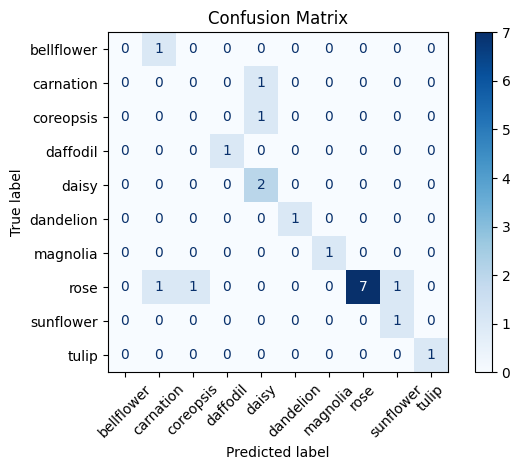

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Extract ground truth and predictions
y_true = [res['actual_label'] for res in results]
y_pred = [str(res['predicted_class']) for res in results]  # Convert to string in case it's a Category type

# Generate confusion matrix
labels = sorted(set(y_true + y_pred))  # Ensures all classes are shown
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()